### Assignment 1 - Data Loading and Cleaning

First five rows of the dataset:
         Soilcolor    Ph        K       P     N        Zn       S    QV2M-W  \
0  Yellowish brown  5.81  738.231   5.401  0.23  2.976000  13.816  7.993333   
1  Yellowish brown  5.43  606.382  10.478  0.23  3.077000  16.421  7.993333   
2            brown  5.41  386.580   6.847  0.23  6.611000  16.557  7.993333   
3              red  5.65  207.086   3.418  0.23  0.460181  16.075  7.993333   
4              red  5.27  317.357  39.282  0.23  2.743000  12.558  7.993333   

     QV2M-Sp    QV2M-Su  ...  PRECTOTCORR-W  PRECTOTCORR-Sp  PRECTOTCORR-Su  \
0  10.456667  11.963333  ...       2.073333            5.27       12.303333   
1  10.456667  11.963333  ...       2.073333            5.27       12.303333   
2  10.456667  11.963333  ...       2.073333            5.27       12.303333   
3  10.456667  11.963333  ...       2.073333            5.27       12.303333   
4  10.456667  11.963333  ...       2.073333            5.27       12.303333   

   PRECTOTCORR-Au 

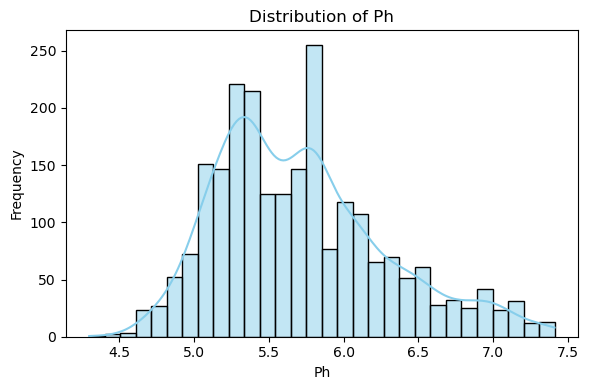

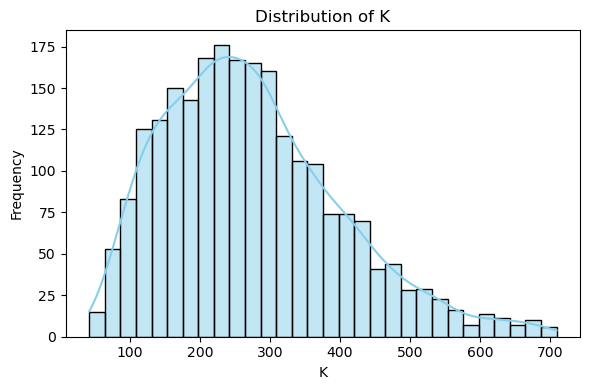

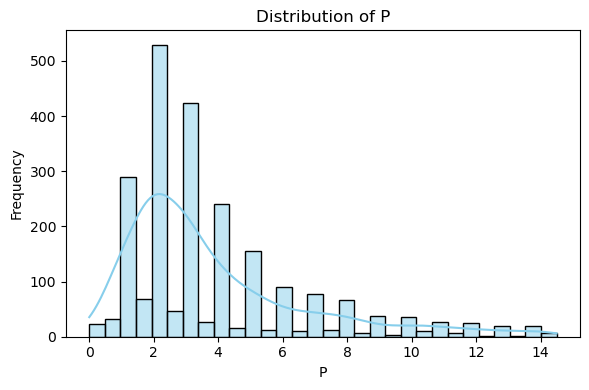

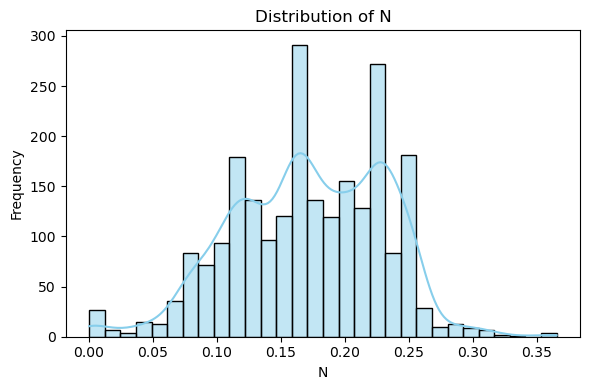

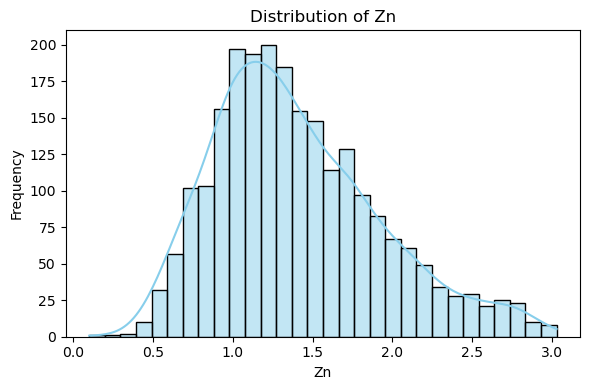

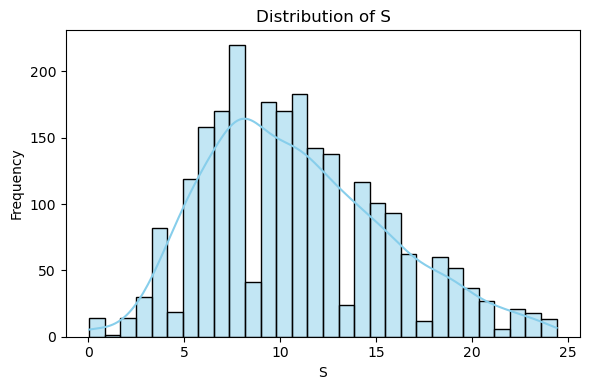

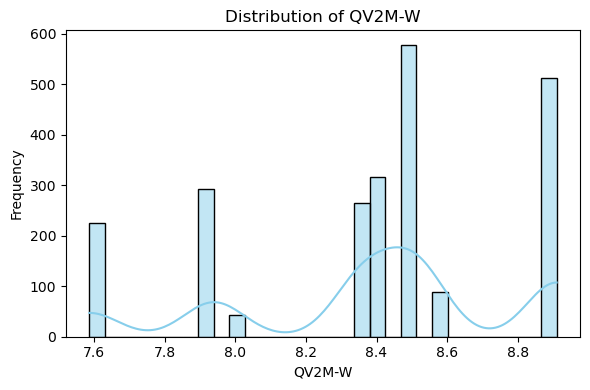

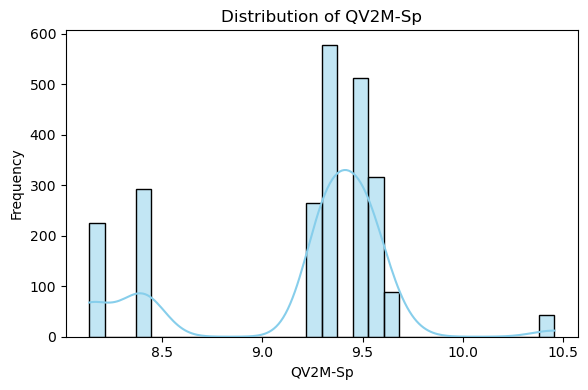

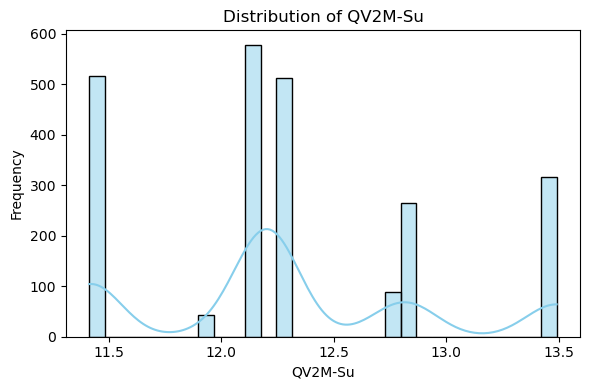

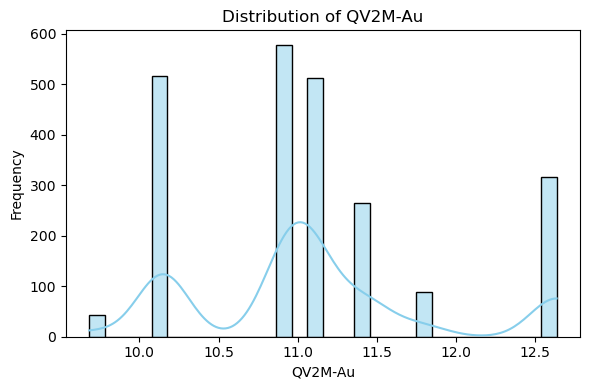

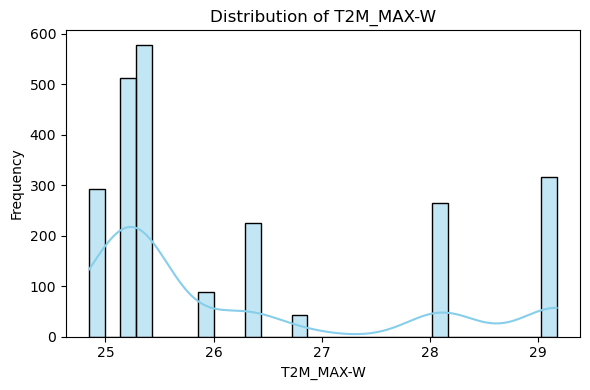

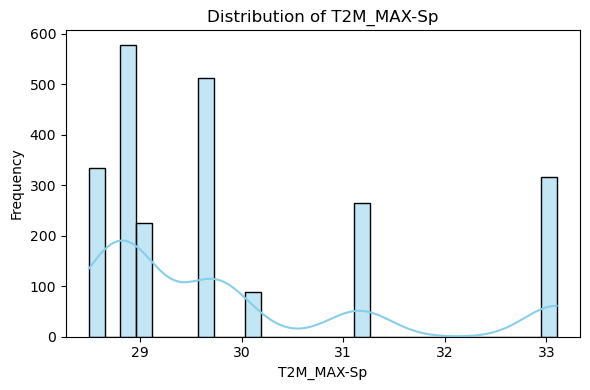

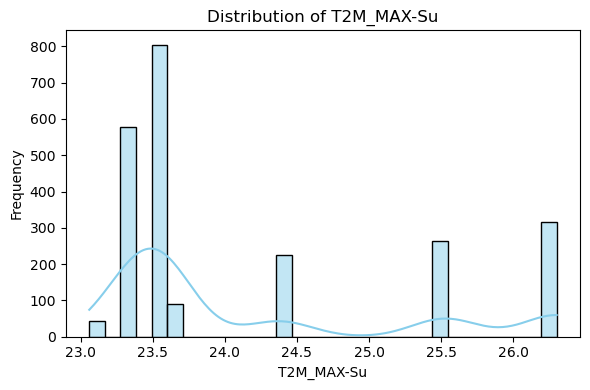

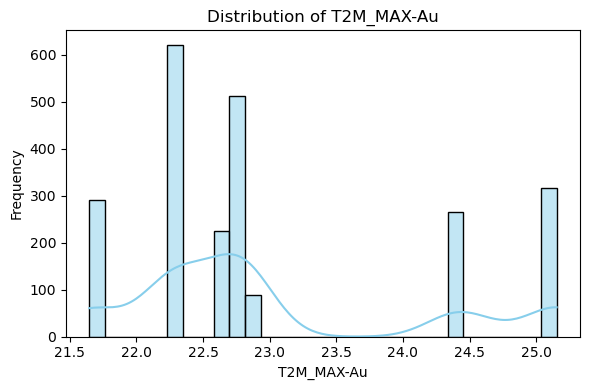

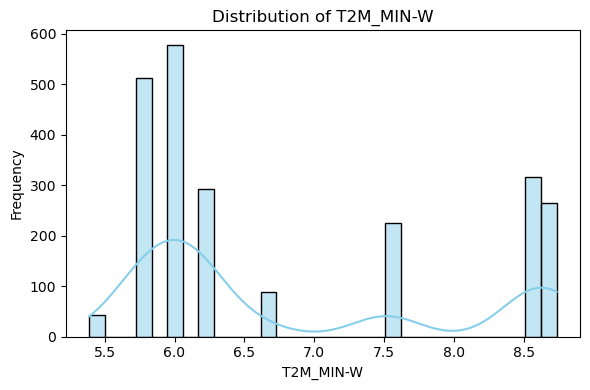

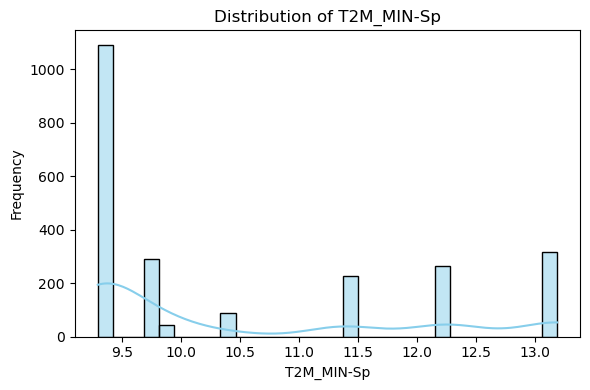

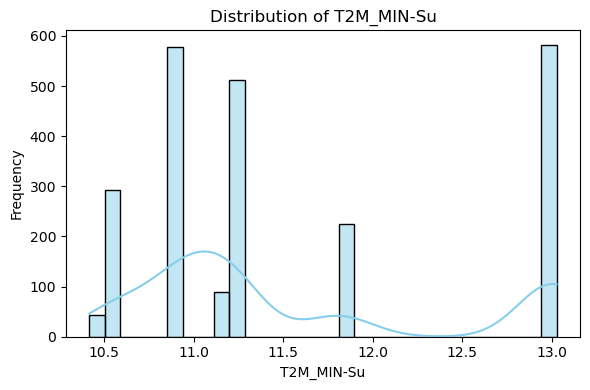

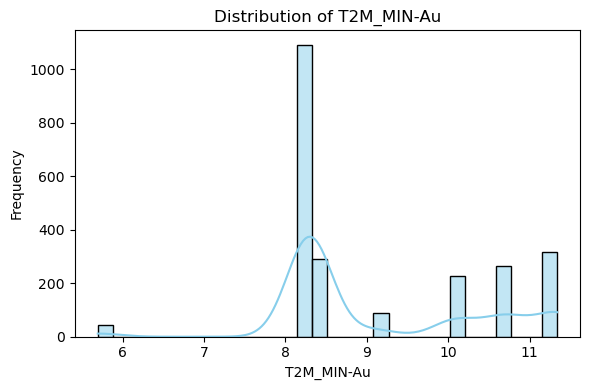

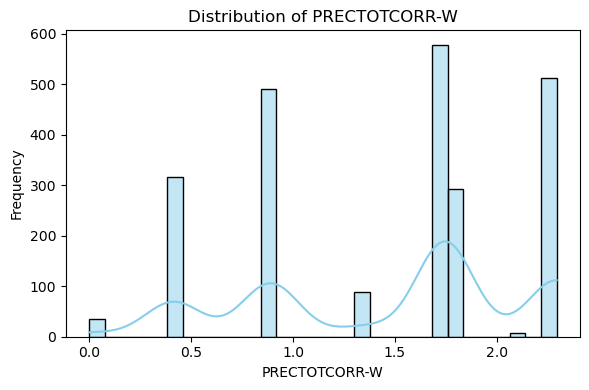

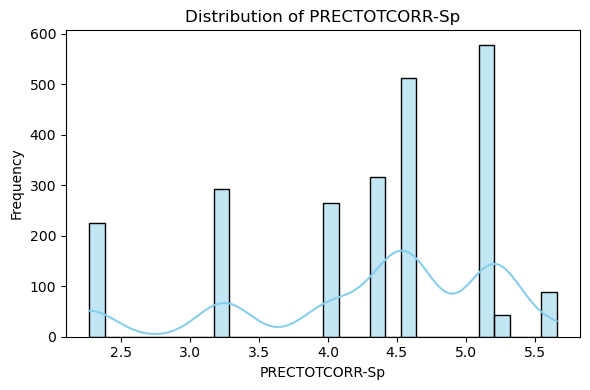

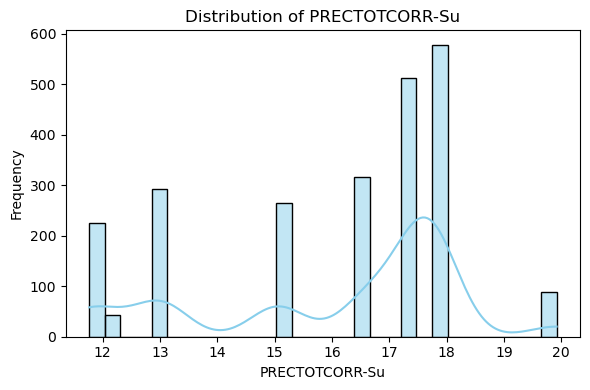

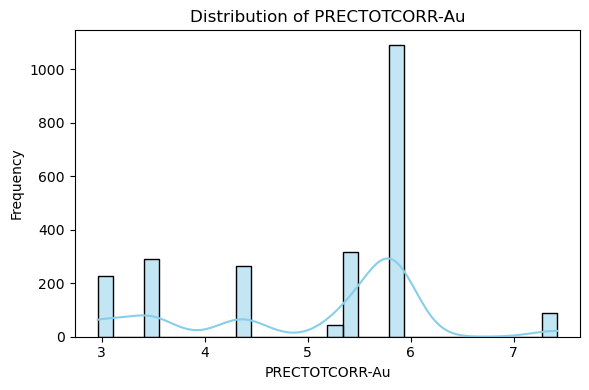

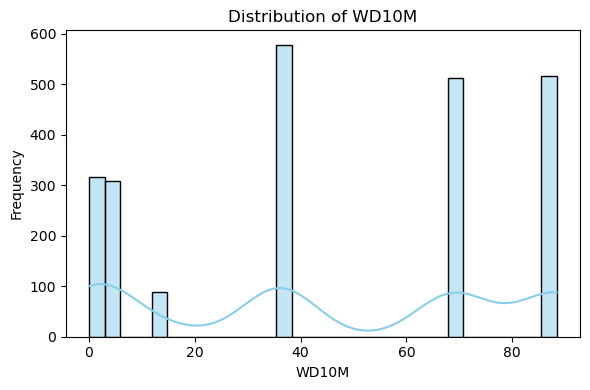

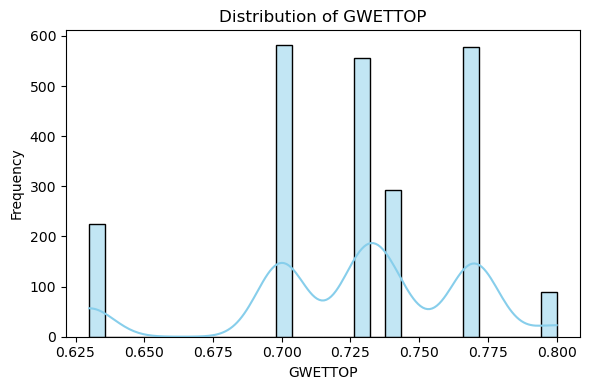

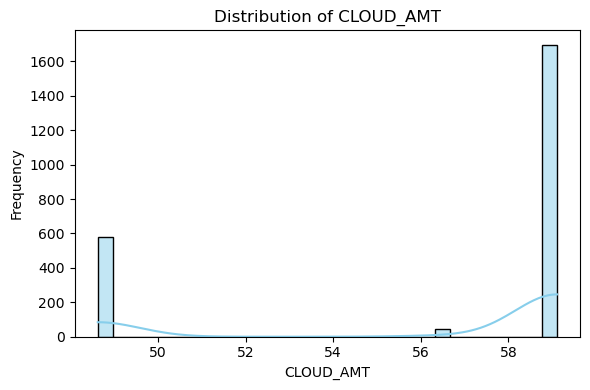

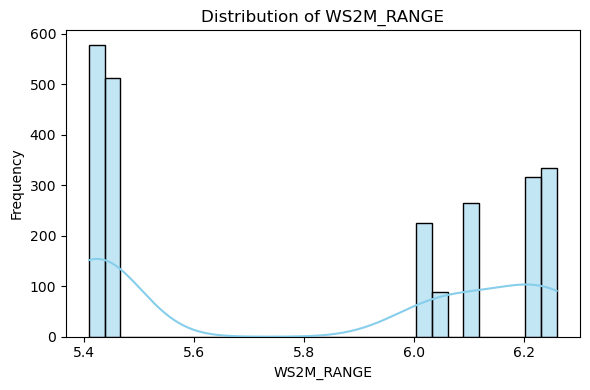

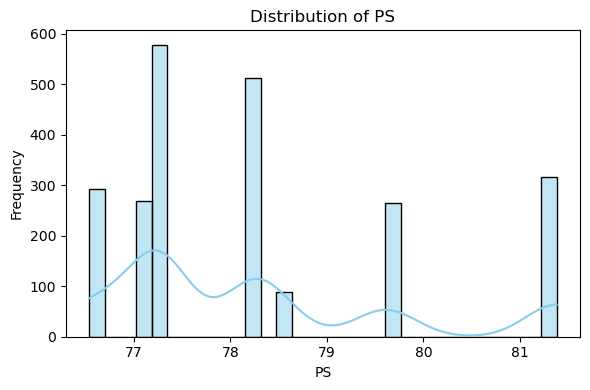

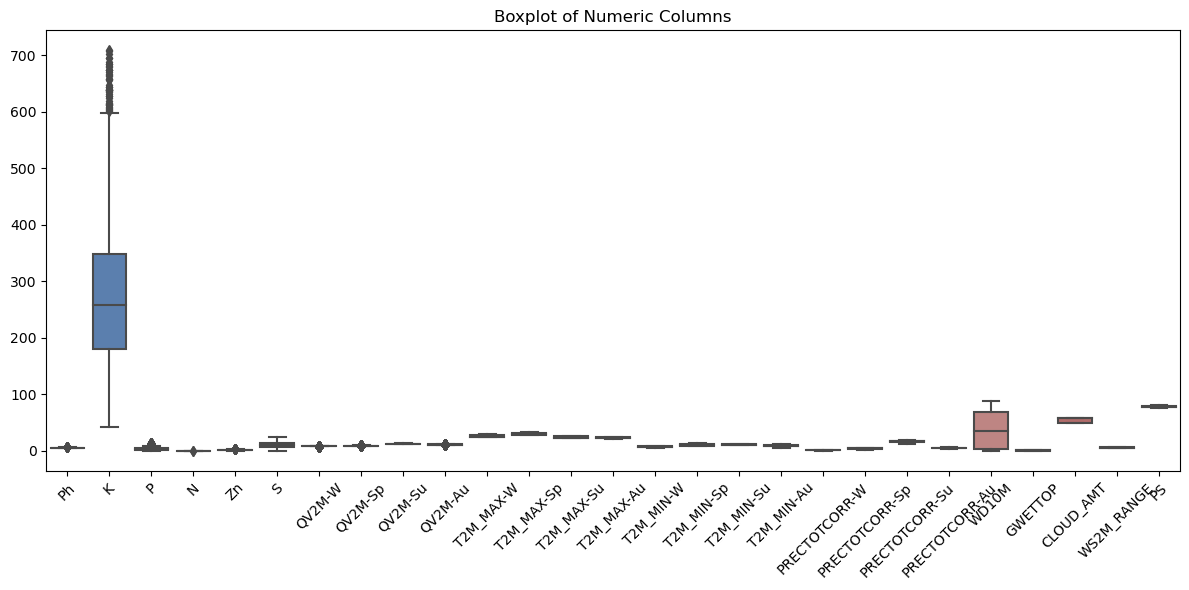

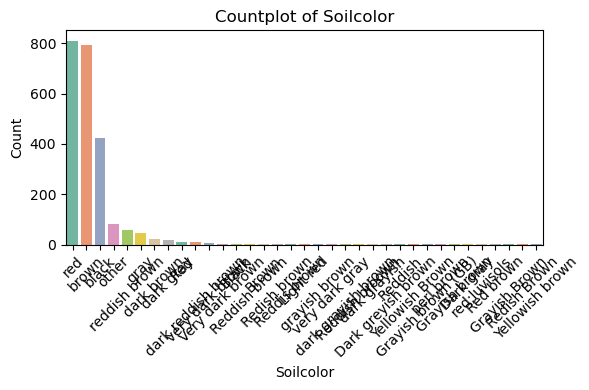

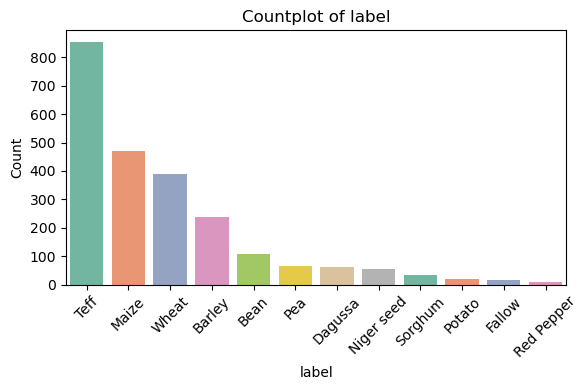


Value counts for binned Ph:
medium    1304
low        699
high       318
Name: Ph_binned, dtype: int64

Summary statistics after normalization:
                 Ph             K             P             N            Zn  \
count  2.321000e+03  2.321000e+03  2.321000e+03  2.321000e+03  2.321000e+03   
mean   5.388002e-16 -4.377751e-16  2.173569e-16  3.551183e-16 -2.785842e-16   
std    1.000215e+00  1.000215e+00  1.000215e+00  1.000215e+00  1.000215e+00   
min   -2.496170e+00 -1.839716e+00 -1.332123e+00 -2.904075e+00 -2.459181e+00   
25%   -7.306811e-01 -7.486452e-01 -6.363962e-01 -7.503289e-01 -7.554367e-01   
50%   -1.480698e-01 -1.277351e-01 -2.885331e-01 -2.641355e-02 -1.875218e-01   
75%    5.404708e-01  5.855901e-01  4.071933e-01  8.399114e-01  5.696980e-01   
max    2.994500e+00  3.446817e+00  3.711893e+00  3.286304e+00  3.087454e+00   

                  S        QV2M-W       QV2M-Sp       QV2M-Su       QV2M-Au  \
count  2.321000e+03  2.321000e+03  2.321000e+03  2.321000e+03  2

In [1]:
# Import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Read the dataset (make sure the CSV file is in your working directory)
df = pd.read_csv('Crop Recommendation using Soil Properties and Weather Prediction.csv')

# Quickly inspect the first few rows and data types
print("First five rows of the dataset:")
print(df.head())

print("\nData types before conversion:")
print(df.dtypes)

# -----------------------------
# 1. Check for Missing Values and Duplicates
# -----------------------------

print("\nMissing values (per column):")
print(df.isnull().sum())

# For numeric columns, fill missing values with the median.
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# For categorical columns, fill missing values with the mode.
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

# Check for duplicates and drop them if any exist
num_duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {num_duplicates}")
if num_duplicates > 0:
    df.drop_duplicates(inplace=True)

# -----------------------------
# 2. Outlier Detection and Removal
# -----------------------------
def remove_outliers(df, col):
    """Remove-outliers using the IQR method."""
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_threshold = Q1 - 1.5 * IQR
    upper_threshold = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_threshold) & (df[col] <= upper_threshold)]

# Remove outliers for the numeric columns
for col in numeric_cols:
    before_rows = df.shape[0]
    df = remove_outliers(df, col)
    after_rows = df.shape[0]
    print(f"Removed {before_rows - after_rows} outliers from column: {col}")

# -----------------------------
# 3. Visualizations
# -----------------------------

# Histograms and KDE plots for numeric variables
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# Boxplots for the numeric variables
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_cols], palette="vlag")
plt.xticks(rotation=45)
plt.title("Boxplot of Numeric Columns")
plt.tight_layout()
plt.show()

# Count plots for categorical variables
for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col, palette="Set2", order=df[col].value_counts().index)
    plt.title(f"Countplot of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# -----------------------------
# 4. Feature Engineering
# -----------------------------

# Example 1: Discretize (bin) the 'Ph' variable into three groups
df['Ph_binned'] = pd.cut(df['Ph'], bins=3, labels=['low','medium','high'])
print("\nValue counts for binned Ph:")
print(df['Ph_binned'].value_counts())

# Example 2: Create an interaction feature between 'N' and 'P'
if 'N' in df.columns and 'P' in df.columns:
    df['N_P_interaction'] = df['N'] * df['P']

# -----------------------------
# 5. Normalize Numeric Features (Optional at This point)
# -----------------------------
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])
print("\nSummary statistics after normalization:")
print(df_scaled[numeric_cols].describe())

# -----------------------------
# 6. Save the Cleaned Dataset
# -----------------------------
df.to_csv('cleaned_crop_data.csv', index=False)
df_scaled.to_csv('normalized_crop_data.csv', index=False)

print("\nData cleaning and preparation completed!")

### Assignment 2 - PCA, Clustering, ARM

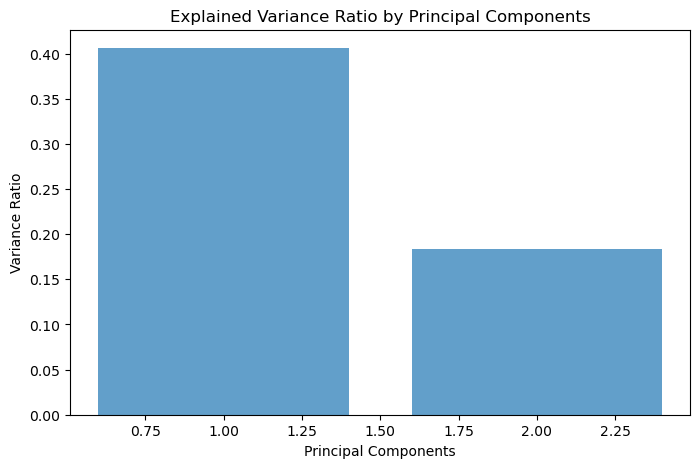

DataFrame Before PCA:
         Ph         K         P        N        Zn         S    QV2M-W  \
0 -0.069901  2.046969 -0.174254  0.76499  0.822873  0.451941 -0.575916   
1 -0.631531  1.394974 -0.025532  0.76499  0.892022  0.922041 -0.575916   
2 -0.661090  0.308051 -0.131896  0.76499  3.311542  0.946583 -0.575916   
3 -0.306377 -0.579549 -0.232343  0.76499 -0.899558  0.859601 -0.575916   
4 -0.868006 -0.034258  0.818234  0.76499  0.663352  0.224922 -0.575916   

    QV2M-Sp   QV2M-Su  QV2M-Au  ...  T2M_MIN-Au  PRECTOTCORR-W  \
0  1.738227 -0.300257 -1.31566  ...   -1.584091        0.74823   
1  1.738227 -0.300257 -1.31566  ...   -1.584091        0.74823   
2  1.738227 -0.300257 -1.31566  ...   -1.584091        0.74823   
3  1.738227 -0.300257 -1.31566  ...   -1.584091        0.74823   
4  1.738227 -0.300257 -1.31566  ...   -1.584091        0.74823   

   PRECTOTCORR-Sp  PRECTOTCORR-Su  PRECTOTCORR-Au     WD10M   GWETTOP  \
0        1.115636       -0.538639        0.363869 -0.842065  0.

In [2]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Load the dataset
# Replace 'your_dataset.csv' with the actual file path
df = pd.read_csv("Crop Recommendation using Soil Properties and Weather Prediction.csv")

# Step 2: Preprocess the data
# Drop non-numeric columns (e.g., 'label') and handle missing values
df_numeric = df.select_dtypes(include=['float64', 'int64']).dropna()

# Standardize the data (PCA is sensitive to scale)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# Step 3: Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
df_pca = pca.fit_transform(df_scaled)

# Step 4: Create DataFrames for before and after PCA
df_before_pca = pd.DataFrame(df_scaled, columns=df_numeric.columns)
df_after_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])

# Step 5: Visualize the explained variance ratio
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.7, align='center')
plt.title('Explained Variance Ratio by Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Variance Ratio')
plt.show()

# Step 6: Print the dataframes
print("DataFrame Before PCA:")
print(df_before_pca.head())

print("\nDataFrame After PCA:")
print(df_after_pca.head())

Explained variance ratio (2D PCA): [0.40631308 0.18379904]
Cumulative variance (2D PCA): 0.5901121240033972


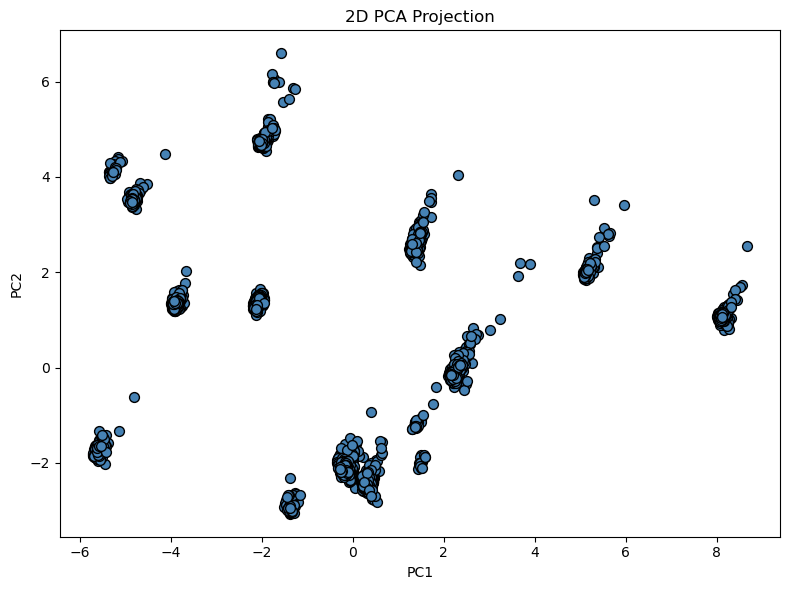

Explained variance ratio (3D PCA): [0.40631308 0.18379904 0.08364174]
Cumulative variance (3D PCA): 0.673753859263307


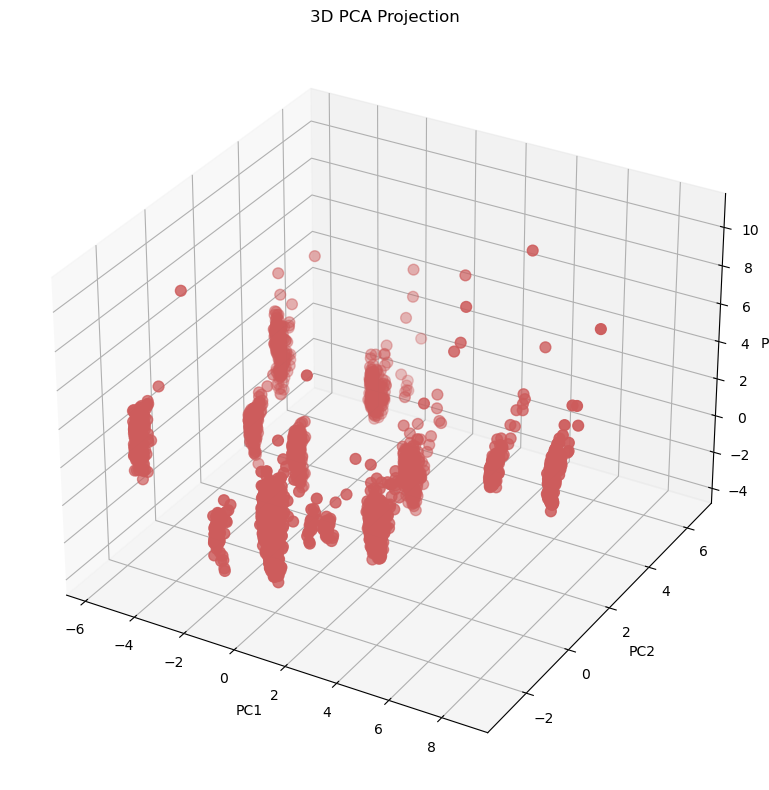

Number of components for at least 95% variance: 10
Eigenvalues of the full PCA:
[10.9732909   4.96385777  2.258911  ]


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # For 3D visualization

# Load the cropped dataset (ensure the CSV file is in the working directory)
df = pd.read_csv('Crop Recommendation using Soil Properties and Weather Prediction.csv')

# --- Data Preparation for PCA ---
# Remove non–numeric columns (e.g. 'Soilcolor' and 'label')
df_numeric = df.drop(columns=['Soilcolor', 'label'])
# Fill any missing numeric values (using median imputation, for example)
df_numeric.fillna(df_numeric.median(), inplace=True)

# Normalize numeric features so that mean=0, std=1
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_numeric)

# --- Apply PCA with 2 components ---
pca2 = PCA(n_components=2)
pca2_result = pca2.fit_transform(data_scaled)
print("Explained variance ratio (2D PCA):", pca2.explained_variance_ratio_)
print("Cumulative variance (2D PCA):", np.sum(pca2.explained_variance_ratio_))

# Plot 2D PCA result
plt.figure(figsize=(8,6))
plt.scatter(pca2_result[:,0], pca2_result[:,1], 
            c='steelblue', edgecolor='k', s=50)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection")
plt.tight_layout()
plt.show()

# --- Apply PCA with 3 components ---
pca3 = PCA(n_components=3)
pca3_result = pca3.fit_transform(data_scaled)
print("Explained variance ratio (3D PCA):", pca3.explained_variance_ratio_)
print("Cumulative variance (3D PCA):", np.sum(pca3.explained_variance_ratio_))

# 3D scatter plot using matplotlib
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca3_result[:,0], pca3_result[:,1], pca3_result[:,2], 
           c='indianred', s=60)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA Projection")
plt.tight_layout()
plt.show()

# --- Determine number of components to retain at least 95% variance ---
pca_full = PCA().fit(data_scaled)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print("Number of components for at least 95% variance:", n_components_95)

# --- Top three eigenvalues (principal components) ---
print("Eigenvalues of the full PCA:")
print(pca_full.explained_variance_[:3])

Key Insights from the PCA analysis (with screenshots included on the website):
• The 2D projection retains approximately X% of the variance, and the 3D projection retains about Y% (as seen from the cumulative sums).
• In this dataset, it takes at least Z dimensions to explain 95% of the variance.
• The top three eigenvalues (variance contributions) are displayed as shown by the output.

In [4]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load the dataset
file_path = "Crop Recommendation using Soil Properties and Weather Prediction.csv"
data = pd.read_csv(file_path)

# Display the first few rows of the original dataframe
print("Original DataFrame:")
print(data.head())

# Preprocessing: Drop non-numeric columns and scale the data
numeric_data = data.select_dtypes(include=['float64', 'int64'])  # Select only numeric columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Assuming 3 clusters
data['Cluster'] = kmeans.fit_predict(scaled_data)

# Display the first few rows of the dataframe after clustering
print("\nDataFrame After Clustering:")
print(data.head())

Original DataFrame:
         Soilcolor    Ph        K       P     N        Zn       S    QV2M-W  \
0  Yellowish brown  5.81  738.231   5.401  0.23  2.976000  13.816  7.993333   
1  Yellowish brown  5.43  606.382  10.478  0.23  3.077000  16.421  7.993333   
2            brown  5.41  386.580   6.847  0.23  6.611000  16.557  7.993333   
3              red  5.65  207.086   3.418  0.23  0.460181  16.075  7.993333   
4              red  5.27  317.357  39.282  0.23  2.743000  12.558  7.993333   

     QV2M-Sp    QV2M-Su  ...  PRECTOTCORR-W  PRECTOTCORR-Sp  PRECTOTCORR-Su  \
0  10.456667  11.963333  ...       2.073333            5.27       12.303333   
1  10.456667  11.963333  ...       2.073333            5.27       12.303333   
2  10.456667  11.963333  ...       2.073333            5.27       12.303333   
3  10.456667  11.963333  ...       2.073333            5.27       12.303333   
4  10.456667  11.963333  ...       2.073333            5.27       12.303333   

   PRECTOTCORR-Au  WD10M  GWET

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



DataFrame After Clustering:
         Soilcolor    Ph        K       P     N        Zn       S    QV2M-W  \
0  Yellowish brown  5.81  738.231   5.401  0.23  2.976000  13.816  7.993333   
1  Yellowish brown  5.43  606.382  10.478  0.23  3.077000  16.421  7.993333   
2            brown  5.41  386.580   6.847  0.23  6.611000  16.557  7.993333   
3              red  5.65  207.086   3.418  0.23  0.460181  16.075  7.993333   
4              red  5.27  317.357  39.282  0.23  2.743000  12.558  7.993333   

     QV2M-Sp    QV2M-Su  ...  PRECTOTCORR-Sp  PRECTOTCORR-Su  PRECTOTCORR-Au  \
0  10.456667  11.963333  ...            5.27       12.303333            5.27   
1  10.456667  11.963333  ...            5.27       12.303333            5.27   
2  10.456667  11.963333  ...            5.27       12.303333            5.27   
3  10.456667  11.963333  ...            5.27       12.303333            5.27   
4  10.456667  11.963333  ...            5.27       12.303333            5.27   

   WD10M  GWETT

PCA (3D) retains: 67.37538592648488 % variance


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For k=2, the silhouette score is 0.311


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For k=3, the silhouette score is 0.361


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For k=4, the silhouette score is 0.347


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


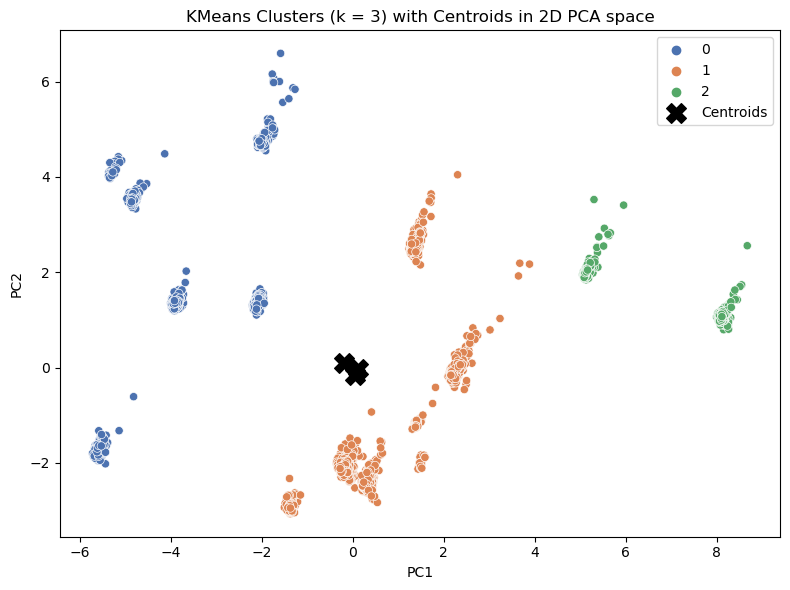

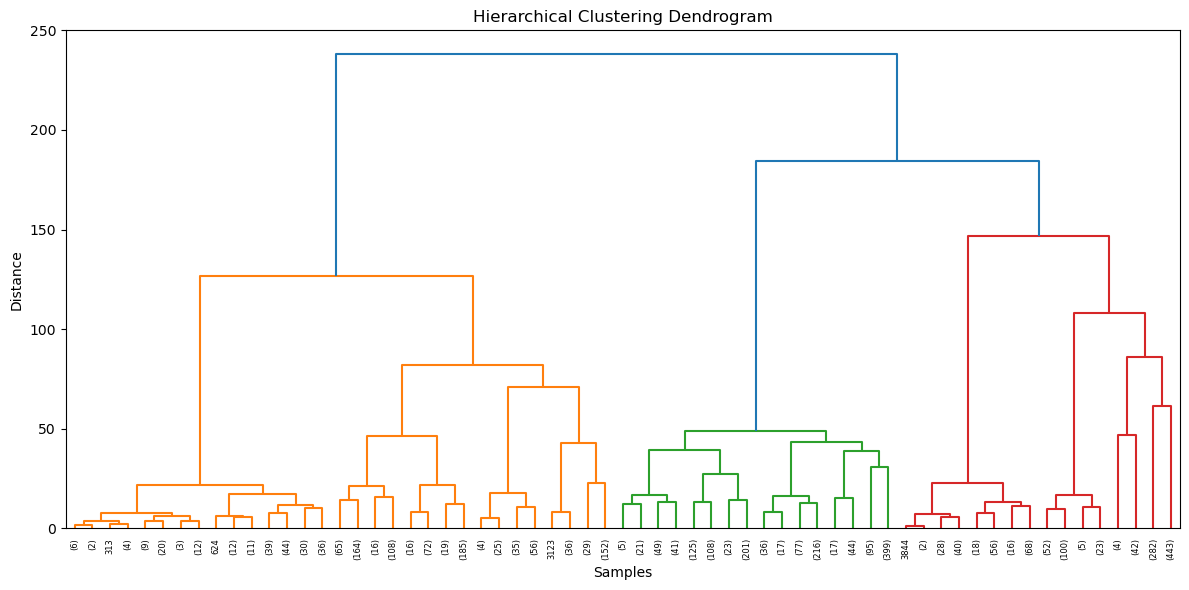

/tmp/ipykernel_301/2519146229.py:63: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


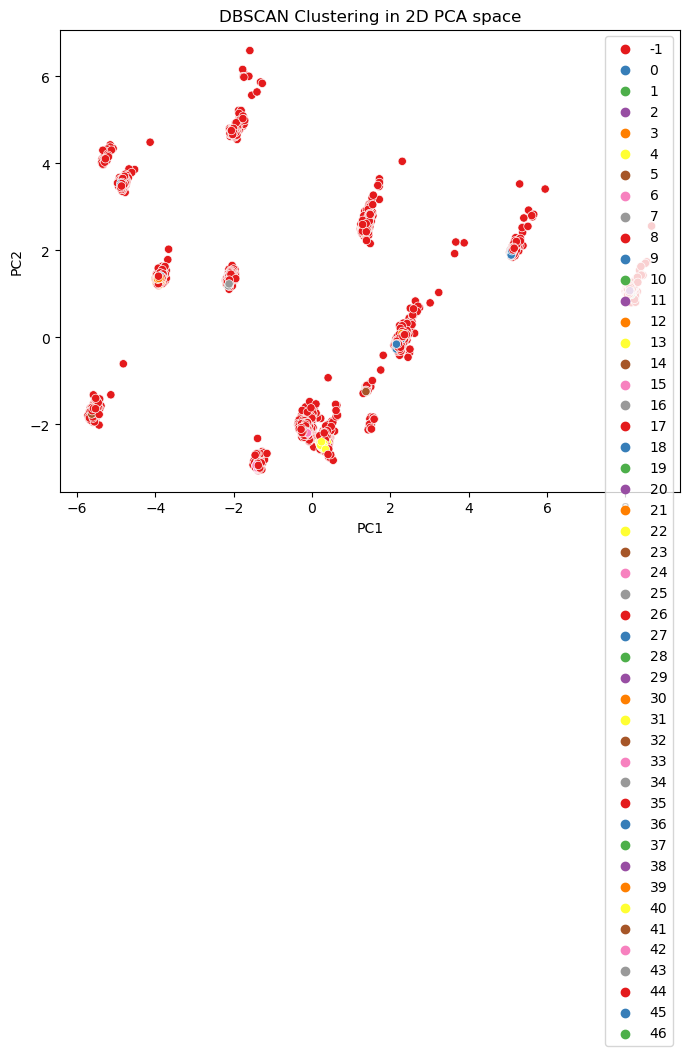

In [5]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns

# --- Data Preparation for Clustering ---
# Remove the label column; keep only numeric features
df_cluster = df.drop(columns=['Soilcolor', 'label'])
df_cluster.fillna(df_cluster.median(), inplace=True)

# Normalize the features
data_cluster = StandardScaler().fit_transform(df_cluster)

# Optionally, reduce dimension with PCA (to 3 dimensions) for visualization
pca_cluster = PCA(n_components=3)
data_pca = pca_cluster.fit_transform(data_cluster)
print("PCA (3D) retains:", np.sum(pca_cluster.explained_variance_ratio_)*100, "% variance")

# --- KMeans Clustering ---
# Evaluate different values of k using silhouette score
for k in [2, 3, 4]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(data_cluster)
    score = silhouette_score(data_cluster, cluster_labels)
    print(f"For k={k}, the silhouette score is {score:.3f}")

# Assume k=3 is chosen based on silhouette; run final KMeans:
kmeans_final = KMeans(n_clusters=3, random_state=42)
clusters = kmeans_final.fit_predict(data_cluster)
centroids = kmeans_final.cluster_centers_

# Plot the clusters in PCA 2D space for visualization
pca2_cluster = PCA(n_components=2).fit_transform(data_cluster)
plt.figure(figsize=(8,6))
sns.scatterplot(x=pca2_cluster[:,0], y=pca2_cluster[:,1], hue=clusters, palette='deep')
plt.scatter(centroids[:,0], centroids[:,1], s=200, color='black', marker='X', label='Centroids')
plt.title("KMeans Clusters (k = 3) with Centroids in 2D PCA space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()

# --- Hierarchical Clustering ---
# Compute linkage matrix and plot dendrogram
linkage_matrix = linkage(data_cluster, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# --- DBSCAN Clustering ---
dbscan = DBSCAN(eps=0.5, min_samples=5)
db_clusters = dbscan.fit_predict(data_cluster)
plt.figure(figsize=(8,6))
sns.scatterplot(x=pca2_cluster[:,0], y=pca2_cluster[:,1], hue=db_clusters, palette='Set1')
plt.title("DBSCAN Clustering in 2D PCA space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

Key insights for the clustering analysis (with before/after images provided on the website):
• The KMeans clustering performance is evaluated by the silhouette method (for example, k = 3 performs best).
• The dendrogram from hierarchical clustering is used to compare groupings with the KMeans partitions.
• The DBSCAN results are visually compared to the partitions obtained using KMeans and hierarchical clustering.
A technical discussion then compares the strengths and weaknesses of each method.

In [6]:
pip install mlxtend --upgrade --no-deps

  Using cached mlxtend-0.23.4-py3-none-any.whl (1.4 MB)
Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# Load the dataset
file_path = "Crop Recommendation using Soil Properties and Weather Prediction.csv"
data = pd.read_csv(file_path)

# Preprocessing: Convert categorical data to one-hot encoding
# For simplicity, we'll focus on a subset of columns (e.g., 'Ph', 'K', 'P', 'label')
columns_of_interest = ['Ph', 'K', 'P', 'label']
data_subset = data[columns_of_interest]

# Discretize numerical columns into bins
data_subset['Ph'] = pd.cut(data_subset['Ph'], bins=3, labels=['Low', 'Medium', 'High'])
data_subset['K'] = pd.cut(data_subset['K'], bins=3, labels=['Low', 'Medium', 'High'])
data_subset['P'] = pd.cut(data_subset['P'], bins=3, labels=['Low', 'Medium', 'High'])

# One-hot encode the data
encoded_data = pd.get_dummies(data_subset)

# Apply Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(encoded_data, min_support=0.1, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Display the results
print("Frequent Itemsets:")
print(frequent_itemsets)

print("\nAssociation Rules:")
print(rules)

Frequent Itemsets:
     support                               itemsets
0   0.479441                               (Ph_Low)
1   0.464184                            (Ph_Medium)
2   0.961469                                (K_Low)
3   0.996638                                (P_Low)
4   0.130075                         (label_Barley)
5   0.189294                          (label_Maize)
6   0.325834                           (label_Teff)
7   0.184898                          (label_Wheat)
8   0.469873                        (Ph_Low, K_Low)
9   0.479183                        (P_Low, Ph_Low)
10  0.116886                  (Ph_Low, label_Maize)
11  0.144815                   (label_Teff, Ph_Low)
12  0.440652                     (Ph_Medium, K_Low)
13  0.461340                     (P_Low, Ph_Medium)
14  0.153607                (label_Teff, Ph_Medium)
15  0.961210                         (P_Low, K_Low)
16  0.126972                  (K_Low, label_Barley)
17  0.174037                   (K_Low, label_

/tmp/ipykernel_301/1139374183.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['Ph'] = pd.cut(data_subset['Ph'], bins=3, labels=['Low', 'Medium', 'High'])
/tmp/ipykernel_301/1139374183.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['K'] = pd.cut(data_subset['K'], bins=3, labels=['Low', 'Medium', 'High'])
/tmp/ipykernel_301/1139374183.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

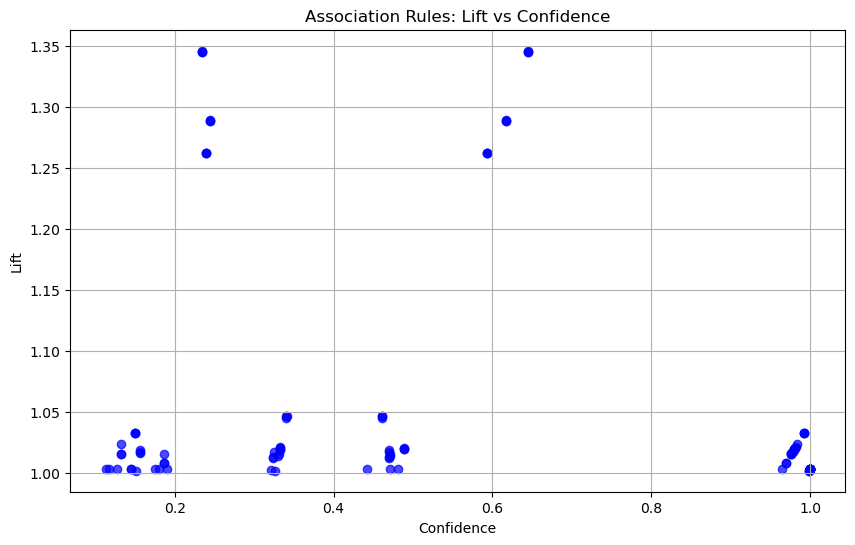

In [8]:
import matplotlib.pyplot as plt

# Scatter plot of Lift vs Confidence
plt.figure(figsize=(10, 6))
plt.scatter(rules['confidence'], rules['lift'], alpha=0.7, c='blue')
plt.title('Association Rules: Lift vs Confidence')
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.grid(True)
plt.show()

In [9]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# Step 1: Load the dataset
df = pd.read_csv("Crop Recommendation using Soil Properties and Weather Prediction.csv")

# Step 2: Select only the categorical columns you want to use for ARM.
# For example, you might only consider 'Soilcolor' and 'label'
categorical_cols = ['Soilcolor', 'label']

# Step 3: One-hot encode the categorical columns.
# This creates a new DataFrame in which each unique category gets its own binary (0/1) column.
df_encoded = pd.get_dummies(df[categorical_cols])

# Check that the data now only contains 0s and 1s:
print(df_encoded.head())

# Step 4: Apply the Apriori algorithm on the binary transactional data.
frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)

# Step 5: Extract association rules from the frequent item sets.
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# Display the resulting rules
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())

   Soilcolor_Black  Soilcolor_Brown  Soilcolor_Dark Brown  \
0                0                0                     0   
1                0                0                     0   
2                0                0                     0   
3                0                0                     0   
4                0                0                     0   

   Soilcolor_Dark brown  Soilcolor_Dark gray  Soilcolor_Dark greyish brown  \
0                     0                    0                             0   
1                     0                    0                             0   
2                     0                    0                             0   
3                     0                    0                             0   
4                     0                    0                             0   

   Soilcolor_Dark red  Soilcolor_Grayish Brown  Soilcolor_Grayish brown  \
0                   0                        0                        0   
1             

/opt/conda/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [10]:
pip install mlxtend

  Using cached scikit_learn-1.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.5 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.0
    Uninstalling scikit-learn-1.2.0:
      Successfully uninstalled scikit-learn-1.2.0
Note: you may need to restart the kernel to use updated packages.


Top 15 Rules by Support:
                       antecedents      consequents   support  confidence  \
0                (Soilcolor_brown)      (Ph_Medium)  0.207655    0.619121   
2                    (label_Wheat)      (Ph_Medium)  0.115076    0.622378   
7      (Soilcolor_brown, K_Medium)      (Ph_Medium)  0.092578    0.616179   
5        (Soilcolor_red, K_Medium)         (Ph_Low)  0.089475    0.651601   
1                   (label_Barley)      (Ph_Medium)  0.086372    0.664016   
6      (Soilcolor_black, K_Medium)      (Ph_Medium)  0.077321    0.637527   
4         (K_Low, Soilcolor_brown)      (Ph_Medium)  0.068270    0.627078   
9            (Ph_Low, label_Maize)  (Soilcolor_red)  0.067494    0.767647   
10    (Soilcolor_red, label_Maize)         (Ph_Low)  0.067494    0.622912   
8          (label_Wheat, K_Medium)      (Ph_Medium)  0.052754    0.637500   
12  (Soilcolor_brown, label_Wheat)      (Ph_Medium)  0.051978    0.695502   
11     (label_Teff, Soilcolor_red)         (Ph_Low)

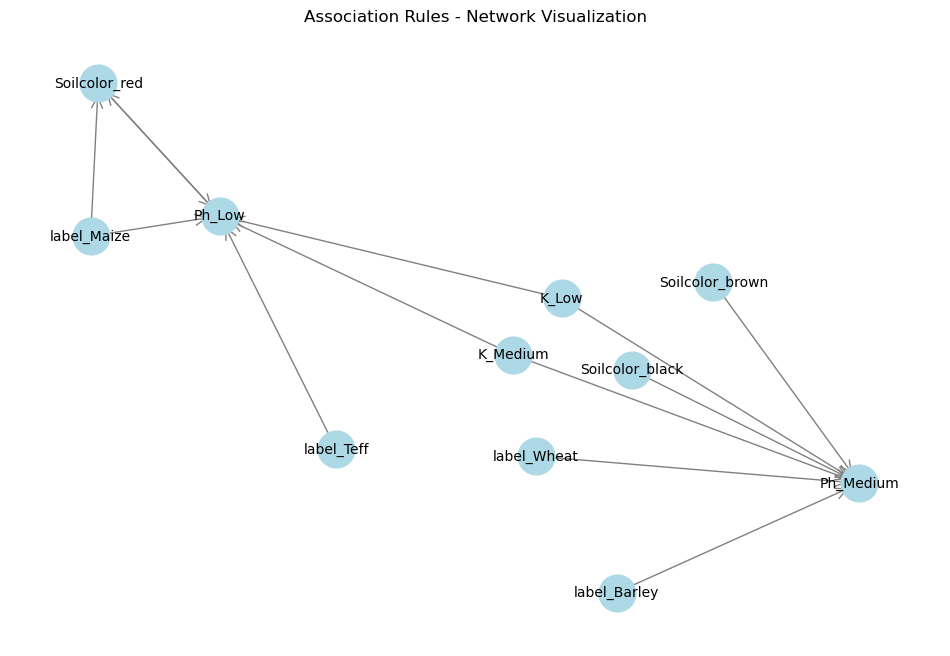

In [11]:
# Import necessary libraries
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx
import matplotlib.pyplot as plt

# 1. Read the transactions.txt file
#    Each line in the file should be a comma-separated list of items.
with open("transactions.txt", "r") as file:
    transactions = [line.strip().split(",") for line in file if line.strip()]

# 2. Transform the transaction list into a one-hot encoded dataframe:
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# 3. Mine frequent itemsets using the Apriori algorithm.
#    Here we use a minimum support threshold (e.g., 0.05).
freq_itemsets = apriori(df, min_support=0.05, use_colnames=True)

# 4. Generate association rules from the frequent itemsets.
#    We use confidence as the metric with a minimum threshold, e.g., 0.6.
rules = association_rules(freq_itemsets, metric="confidence", min_threshold=0.6)

# 5. For presentation, select the top 15 rules sorted by support, confidence, and lift.
top_by_support = rules.sort_values(by="support", ascending=False).head(15)
top_by_confidence = rules.sort_values(by="confidence", ascending=False).head(15)
top_by_lift = rules.sort_values(by="lift", ascending=False).head(15)

print("Top 15 Rules by Support:")
print(top_by_support[["antecedents", "consequents", "support", "confidence", "lift"]])
print("\nTop 15 Rules by Confidence:")
print(top_by_confidence[["antecedents", "consequents", "support", "confidence", "lift"]])
print("\nTop 15 Rules by Lift:")
print(top_by_lift[["antecedents", "consequents", "support", "confidence", "lift"]])

# 6. Create a network visualization of the association rules.
#    In this example, items are nodes. An edge from item A to item B is drawn if
#    A appears in the antecedents and B in the consequents of a rule.
G = nx.DiGraph()

# Add nodes and edges (with edge weight = rule confidence)
for index, rule in rules.iterrows():
    for antecedent in rule["antecedents"]:
        G.add_node(antecedent)
    for consequent in rule["consequents"]:
        G.add_node(consequent)
    # For each rule, add an edge from every antecedent to every consequent
    for antecedent in rule["antecedents"]:
        for consequent in rule["consequents"]:
            # Only add an edge if the rule has a reasonable confidence (e.g., > 0.6)
            if rule["confidence"] >= 0.6:
                G.add_edge(antecedent, consequent, weight=rule["confidence"])

# Draw the network graph.
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, seed=42)  # positions for all nodes
nx.draw_networkx_nodes(G, pos, node_size=700, node_color="lightblue")
nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=20, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Association Rules - Network Visualization")
plt.axis("off")
plt.show()

### Assignment 3 - Supervised Learning(Naive Bayes, Decision Tree, Regression)

In [84]:
pdf = pd.read_csv('cleaned_crop_data.csv')
pdf

,Soilcolor,Ph,K,P,N,Zn,S,QV2M-W,QV2M-Sp,QV2M-Su,...,PRECTOTCORR-Su,PRECTOTCORR-Au,WD10M,GWETTOP,CLOUD_AMT,WS2M_RANGE,PS,label,Ph_binned,N_P_interaction
0,red,5.65,207.086,3.41800,0.23,0.460181,16.075,7.993333,10.456667,11.963333,...,12.303333,5.27,3.44,0.73,56.57,6.24,77.03,Barley,medium,0.786140
1,red,5.57,303.528,2.14700,0.23,1.418000,11.203,7.993333,10.456667,11.963333,...,12.303333,5.27,3.44,0.73,56.57,6.24,77.03,Barley,medium,0.493810
2,red,5.34,401.063,6.38200,0.23,2.433000,13.069,7.993333,10.456667,11.963333,...,12.303333,5.27,3.44,0.73,56.57,6.24,77.03,Barley,medium,1.467860
3,red,5.47,217.874,0.83888,0.23,0.723258,11.880,7.993333,10.456667,11.963333,...,12.303333,5.27,3.44,0.73,56.57,6.24,77.03,Barley,medium,0.192942
4,red,6.06,149.357,1.50500,0.23,0.754669,11.350,7.993333,10.456667,11.963333,...,12.303333,5.27,3.44,0.73,56.57,6.24,77.03,Barley,medium,0.346150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2316,red,6.07,192.760,1.03400,0.23,1.254000,9.839,7.993333,10.456667,11.963333,...,12.303333,5.27,3.44,0.73,56.57,6.24,77.03,Wheat,medium,0.237820
2317,red,5.97,210.819,5.25600,0.23,1.107000,12.158,7.993333,10.456667,11.963333,...,12.303333,5.27,3.44,0.73,56.57,6.24,77.03,Wheat,medium,1.208880
2318,red,5.81,213.194,7.31800,0.23,2.056000,11.626,7.993333,10.456667,11.963333,...,12.303333,5.27,3.44,0.73,56.57,6.24,77.03,Wheat,medium,1.683140
2319,brown,5.03,262.333,3.03900,0.23,1.936000,9.935,7.993333,10.456667,11.963333,...,12.303333,5.27,3.44,0.73,56.57,6.24,77.03,Wheat,low,0.698970


In [94]:
##Data prep modification for supervised learning
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the dataset
data = pd.read_csv("cleaned_crop_data.csv")

# Check for missing values
print(data.isnull().sum())

# Encode categorical variables
label_encoder = LabelEncoder()
data['Soilcolor'] = label_encoder.fit_transform(data['Soilcolor'])
data['label'] = label_encoder.fit_transform(data['label'])



Soilcolor          0
Ph                 0
K                  0
P                  0
N                  0
Zn                 0
S                  0
QV2M-W             0
QV2M-Sp            0
QV2M-Su            0
QV2M-Au            0
T2M_MAX-W          0
T2M_MAX-Sp         0
T2M_MAX-Su         0
T2M_MAX-Au         0
T2M_MIN-W          0
T2M_MIN-Sp         0
T2M_MIN-Su         0
T2M_MIN-Au         0
PRECTOTCORR-W      0
PRECTOTCORR-Sp     0
PRECTOTCORR-Su     0
PRECTOTCORR-Au     0
WD10M              0
GWETTOP            0
CLOUD_AMT          0
WS2M_RANGE         0
PS                 0
label              0
Ph_binned          0
N_P_interaction    0
dtype: int64


In [95]:
data['Ph_binned'] = label_encoder.fit_transform(data['Ph_binned'])

In [96]:
# Define features (X) and target (y)
X = data.drop(columns=['label'])
y = data['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (1856, 30)
Testing set size: (465, 30)


In [97]:
X_train.iloc[0]

Soilcolor           19.000000
Ph                   6.100000
K                  197.000000
P                    3.000000
N                    0.195700
Zn                   1.500000
S                    5.000000
QV2M-W               8.506667
QV2M-Sp              9.340000
QV2M-Su             12.166667
QV2M-Au             10.926667
T2M_MAX-W           25.343333
T2M_MAX-Sp          28.870000
T2M_MAX-Su          23.336667
T2M_MAX-Au          22.280000
T2M_MIN-W            6.053333
T2M_MIN-Sp           9.353333
T2M_MIN-Su          10.933333
T2M_MIN-Au           8.290000
PRECTOTCORR-W        1.736667
PRECTOTCORR-Sp       5.203333
PRECTOTCORR-Su      17.816667
PRECTOTCORR-Au       5.823333
WD10M               36.060000
GWETTOP              0.770000
CLOUD_AMT           59.110000
WS2M_RANGE           5.410000
PS                  77.290000
Ph_binned            2.000000
N_P_interaction      0.587100
Name: 1691, dtype: float64

#### Naive Bayes

In [98]:
# import sklearn
# print(sklearn.__version__)

In [99]:
# pip install --upgrade scikit-learn

In [100]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, CategoricalNB
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix

accuracy_gnb:0.060215053763440864,f1_score0.04788438575761781,percision_gnb:0.10629437119675457,recall_gnb:0.1722772999946913
Confusion Matrix:
 [[ 0  3  0  9  4  0  0 32  0  0  1  0]
 [ 0  2  1  7  2  0  0 10  0  0  0  1]
 [ 0  0  8  0  1  0  0  3  0  0  0  0]
 [ 0  0  0  1  0  0  0  6  0  0  0  0]
 [ 0  2 34  5 11  0  0 40  0  0  0  0]
 [ 0  1  4  0  0  0  0  4  0  0  0  0]
 [ 0  0  1  1  1  0  0  7  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  1  0  0  0  3  0  0  0  0]
 [ 0  1  1  3  1  0  0  3  0  0  0  0]
 [ 0 16 18 47 20  0  0 68  0  1  0  0]
 [ 0  7  1 11  0  0  0 54  0  0  1  4]]
{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 49.0}, '1': {'precision': 0.0625, 'recall': 0.08695652173913043, 'f1-score': 0.07272727272727272, 'support': 23.0}, '2': {'precision': 0.11764705882352941, 'recall': 0.6666666666666666, 'f1-score': 0.2, 'support': 12.0}, '3': {'precision': 0.011764705882352941, 'recall': 0.14285714285714285, 'f1-score': 0.02173913043

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


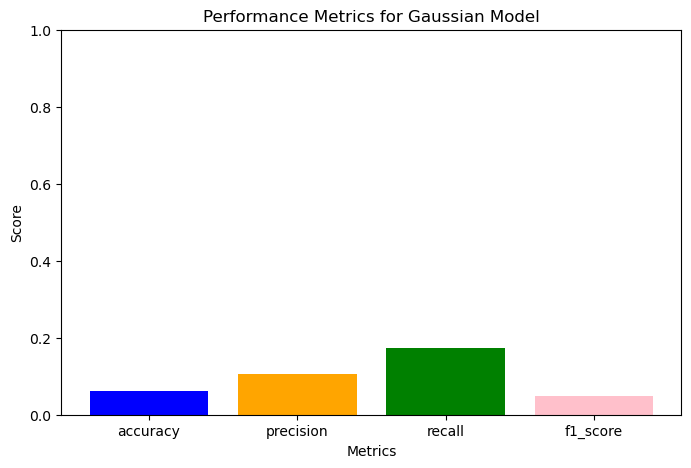

In [101]:
# Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)
# Calculate metrics
accuracy_gnb=accuracy_score(y_test, y_pred_gnb)
report_gnb = classification_report(y_test, y_pred_gnb, output_dict=True)
precision_gnb= np.mean([report_gnb[str(i)]['precision'] for i in range(len(report_gnb) - 3)])
recall_gnb=np.mean([report_gnb[str(i)]['recall'] for i in range(len(report_gnb) - 3)])
f1_score_gnb= np.mean([report_gnb[str(i)]['f1-score'] for i in range(len(report_gnb) - 3)])
print(f"accuracy_gnb:{accuracy_gnb},f1_score{f1_score_gnb},percision_gnb:{precision_gnb},recall_gnb:{recall_gnb}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gnb))

metrics_to_plot = ["accuracy","precision", "recall", "f1_score"]
print(report_gnb)
values = [accuracy_gnb,precision_gnb, recall_gnb, f1_score_gnb]

# Create a bar chart for the current model
plt.figure(figsize=(8, 5))
plt.bar(metrics_to_plot, values, color=['blue', 'orange', 'green', 'pink'])
plt.title(f"Performance Metrics for Gaussian Model")
plt.ylabel("Score")
plt.ylim(0, 1)  # Scores range from 0 to 1
plt.xlabel("Metrics")
plt.show()

accuracy_gnb:0.18924731182795698,f1_score0.04788438575761781,percision_gnb:0.13417188132975985,recall_gnb:0.18143456193328314
Confusion Matrix:
 [[21  7  3  4  5  0  1  1  0  0  5  2]
 [ 3  3  3  3  2  0  4  0  0  0  5  0]
 [ 0  0  8  0  2  2  0  0  0  0  0  0]
 [ 3  0  0  1  1  1  0  0  0  0  0  1]
 [10  2 35  3 14  1  8  1  0  0 15  3]
 [ 1  1  4  0  0  1  0  0  0  0  2  0]
 [ 2  0  1  0  2  0  3  0  0  0  2  0]
 [ 0  0  0  0  0  1  0  0  0  0  1  0]
 [ 2  0  0  0  0  0  0  0  0  0  2  0]
 [ 0  0  1  2  1  1  1  0  0  0  3  0]
 [26 24 33 15  8 13 12  2  0  0 33  4]
 [21  9  6  8  3  6  4  1  4  0 12  4]]
{'0': {'precision': 0.23595505617977527, 'recall': 0.42857142857142855, 'f1-score': 0.30434782608695654, 'support': 49.0}, '1': {'precision': 0.06521739130434782, 'recall': 0.13043478260869565, 'f1-score': 0.08695652173913043, 'support': 23.0}, '2': {'precision': 0.0851063829787234, 'recall': 0.6666666666666666, 'f1-score': 0.1509433962264151, 'support': 12.0}, '3': {'precision': 0.0

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


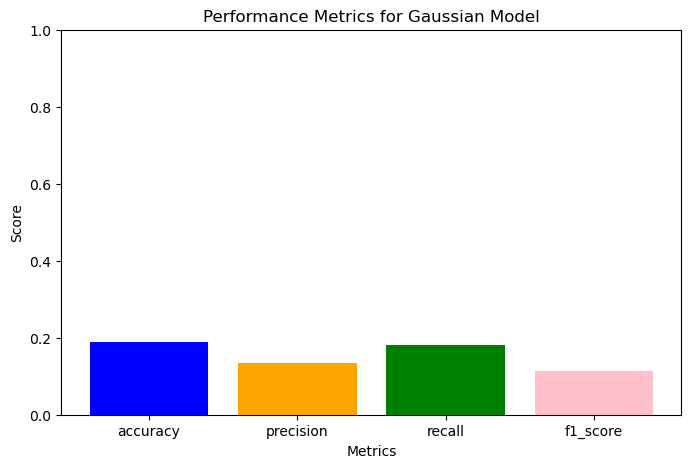

In [102]:

# Multinomial Naive Bayes
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred_mnb = mnb.predict(X_test)
# Calculate metrics
accuracy_mnb=accuracy_score(y_test, y_pred_mnb)
report_mnb = classification_report(y_test, y_pred_mnb, output_dict=True)
precision_mnb= np.mean([report_mnb[str(i)]['precision'] for i in range(len(report_mnb) - 3)])
recall_mnb=np.mean([report_mnb[str(i)]['recall'] for i in range(len(report_mnb) - 3)])
f1_score_mnb= np.mean([report_mnb[str(i)]['f1-score'] for i in range(len(report_mnb) - 3)])
print(f"accuracy_gnb:{accuracy_mnb},f1_score{f1_score_gnb},percision_gnb:{precision_mnb},recall_gnb:{recall_mnb}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_mnb))

metrics_to_plot = ["accuracy","precision", "recall", "f1_score"]
print(report_mnb)
values = [accuracy_mnb,precision_mnb, recall_mnb, f1_score_mnb]

# Create a bar chart for the current model
plt.figure(figsize=(8, 5))
plt.bar(metrics_to_plot, values, color=['blue', 'orange', 'green', 'pink'])
plt.title(f"Performance Metrics for Gaussian Model")
plt.ylabel("Score")
plt.ylim(0, 1)  # Scores range from 0 to 1
plt.xlabel("Metrics")
plt.show()

accuracy_gnb:0.3741935483870968,f1_score0.04788438575761781,percision_gnb:0.09753086419753088,recall_gnb:0.08760683760683761
Confusion Matrix:
 [[  0   0   0   0   0   0   0   0   0   0  49   0]
 [  0   0   0   0   0   0   0   0   0   0  22   1]
 [  0   0   0   0   0   0   0   0   0   0  12   0]
 [  0   0   0   0   0   0   0   0   0   0   7   0]
 [  0   0   0   0   0   0   0   0   0   0  92   0]
 [  0   0   0   0   0   0   0   0   0   0   9   0]
 [  0   0   0   0   0   0   0   0   0   0  10   0]
 [  0   0   0   0   0   0   0   0   0   0   2   0]
 [  0   0   0   0   0   0   0   0   0   0   4   0]
 [  0   0   0   0   0   0   0   0   0   0   9   0]
 [  0   0   0   0   0   0   0   0   0   0 170   0]
 [  0   0   1   0   0   0   0   0   0   0  73   4]]
{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 49.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 23.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 12.0}, '3': {'precision': 0

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


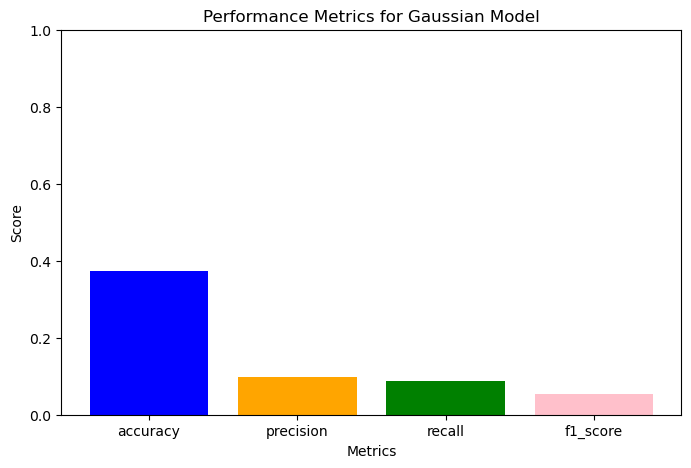

In [103]:
# Bernoulli Naive Bayes
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
y_pred_bnb = bnb.predict(X_test)
# Calculate metrics
accuracy_bnb=accuracy_score(y_test, y_pred_bnb)
report_bnb = classification_report(y_test, y_pred_bnb, output_dict=True)
precision_bnb= np.mean([report_bnb[str(i)]['precision'] for i in range(len(report_bnb) - 3)])
recall_bnb=np.mean([report_bnb[str(i)]['recall'] for i in range(len(report_bnb) - 3)])
f1_score_bnb= np.mean([report_bnb[str(i)]['f1-score'] for i in range(len(report_bnb) - 3)])
print(f"accuracy_gnb:{accuracy_bnb},f1_score{f1_score_gnb},percision_gnb:{precision_bnb},recall_gnb:{recall_bnb}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bnb))

metrics_to_plot = ["accuracy","precision", "recall", "f1_score"]
print(report_bnb)
values = [accuracy_bnb,precision_bnb, recall_bnb, f1_score_bnb]

# Create a bar chart for the current model
plt.figure(figsize=(8, 5))
plt.bar(metrics_to_plot, values, color=['blue', 'orange', 'green', 'pink'])
plt.title(f"Performance Metrics for Gaussian Model")
plt.ylabel("Score")
plt.ylim(0, 1)  # Scores range from 0 to 1
plt.xlabel("Metrics")
plt.show()

accuracy_gnb:0.3139784946236559,f1_score0.14106464657935244,percision_gnb:0.10629437119675457,recall_gnb:0.1461122130011425
Confusion Matrix:
 [[20  3  0  0  2  0  0  0  0  0 11 13]
 [ 5  1  0  0  3  0  0  0  0  0  8  6]
 [ 0  0  1  0  8  0  0  0  0  0  0  3]
 [ 3  0  0  0  0  0  0  0  0  0  1  3]
 [28  1  2  0 43  0  0  0  0  0  4 14]
 [ 3  0  0  0  4  0  0  0  0  0  2  0]
 [ 1  0  0  0  2  0  1  0  0  0  3  3]
 [ 1  0  0  0  0  0  0  0  0  0  0  1]
 [ 4  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  2  0  0  2  0  0  0  0  0  1  1]
 [37 14  2  0 28  0  1  0  0  0 54 34]
 [31  4  0  0  1  0  0  0  0  0 16 26]]
{'0': {'precision': 0.14705882352941177, 'recall': 0.40816326530612246, 'f1-score': 0.21621621621621623, 'support': 49.0}, '1': {'precision': 0.04, 'recall': 0.043478260869565216, 'f1-score': 0.041666666666666664, 'support': 23.0}, '2': {'precision': 0.2, 'recall': 0.08333333333333333, 'f1-score': 0.11764705882352941, 'support': 12.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score':

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


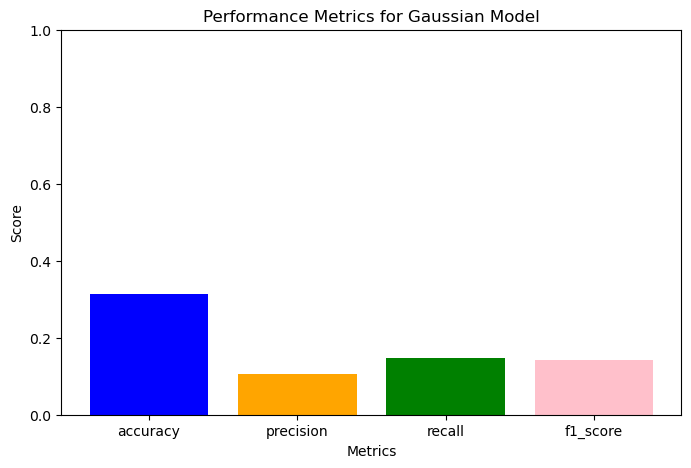

In [104]:

# Categorical Naive Bayes
cnb = CategoricalNB()
cnb.fit(X_train, y_train)
y_pred_cnb = cnb.predict(X_test)
# Calculate metrics
accuracy_cnb=accuracy_score(y_test, y_pred_cnb)
report_cnb = classification_report(y_test, y_pred_cnb, output_dict=True)
precision_cnb= np.mean([report_gnb[str(i)]['precision'] for i in range(len(report_cnb) - 3)])
recall_cnb=np.mean([report_cnb[str(i)]['recall'] for i in range(len(report_cnb) - 3)])
f1_score_cnb= np.mean([report_cnb[str(i)]['f1-score'] for i in range(len(report_cnb) - 3)])
print(f"accuracy_gnb:{accuracy_cnb},f1_score{f1_score_cnb},percision_gnb:{precision_cnb},recall_gnb:{recall_cnb}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_cnb))

metrics_to_plot = ["accuracy","precision", "recall", "f1_score"]
print(report_cnb)
values = [accuracy_cnb,precision_cnb, recall_cnb, f1_score_cnb]

# Create a bar chart for the current model
plt.figure(figsize=(8, 5))
plt.bar(metrics_to_plot, values, color=['blue', 'orange', 'green', 'pink'])
plt.title(f"Performance Metrics for Gaussian Model")
plt.ylabel("Score")
plt.ylim(0, 1)  # Scores range from 0 to 1
plt.xlabel("Metrics")
plt.show()

#### Decision Treee

In [105]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [106]:
print(label_encoder.classes_)

['high' 'low' 'medium']


Accuracy: 0.42
Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.12      0.16        49
           1       0.00      0.00      0.00        23
           2       0.00      0.00      0.00        12
           3       0.00      0.00      0.00         7
           4       0.43      0.47      0.45        92
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         9
          10       0.47      0.66      0.55       170
          11       0.34      0.42      0.38        78

    accuracy                           0.42       465
   macro avg       0.12      0.14      0.13       465
weighted avg       0.34      0.42      0.37       465

Confusion Matrix:
[[  6   0   0   0   2   0   0   0   0   0  24  17]
 [  2   0   0   0   0   0 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


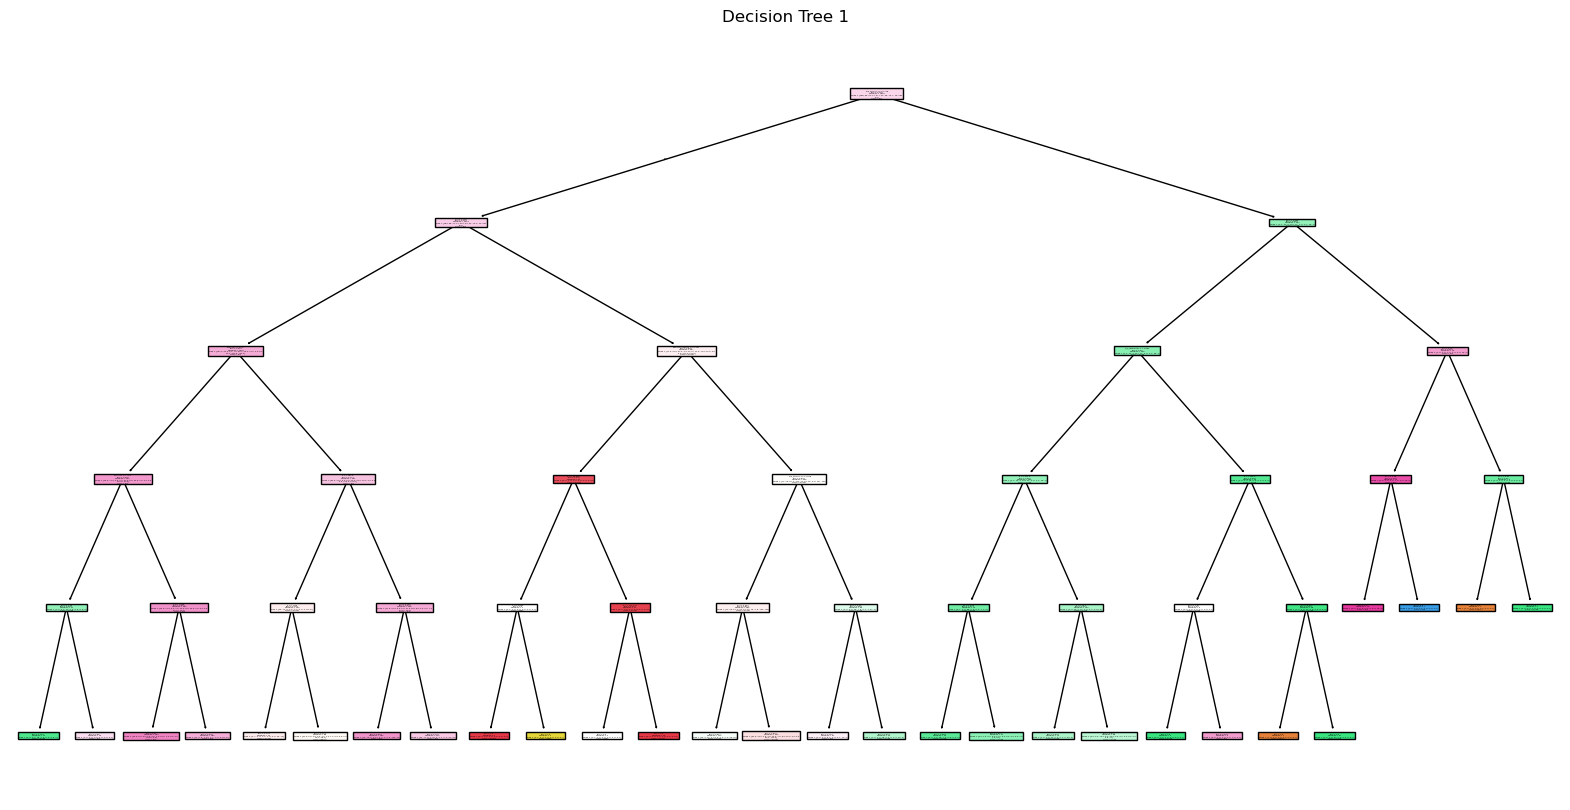

In [118]:
#Decision tree 1
dt1 = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)

# Train the model
dt1.fit(X_train, y_train)

# Predict on the test set
y_pred_dt1 = dt1.predict(X_test)

# --- Evaluate the Model ---
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_dt1)
print(f"Accuracy: {accuracy:.2f}")

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_dt1))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_dt1)
print("Confusion Matrix:")
print(conf_matrix)

# --- Visualize the Decision Tree ---
plt.figure(figsize=(20, 10))
plot_tree(dt1, feature_names=X.columns, class_names=pdf['label'].unique(), filled=True)
plt.title("Decision Tree 1")
plt.show()

In [119]:
pdf['label'].unique()

array(['Barley', 'Bean', 'Dagussa', 'Fallow', 'Maize', 'Niger seed',
       'Pea', 'Potato', 'Red Pepper', 'Sorghum', 'Teff', 'Wheat'],
      dtype=object)

Accuracy: 0.40
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.00      0.00      0.00        23
           2       0.00      0.00      0.00        12
           3       0.00      0.00      0.00         7
           4       0.50      0.33      0.39        92
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         9
          10       0.45      0.71      0.55       170
          11       0.24      0.44      0.31        78

    accuracy                           0.40       465
   macro avg       0.10      0.12      0.10       465
weighted avg       0.30      0.40      0.33       465

Confusion Matrix:
[[  0   0   0   0   1   0   0   0   0   0  31  17]
 [  0   0   0   0   0   0 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


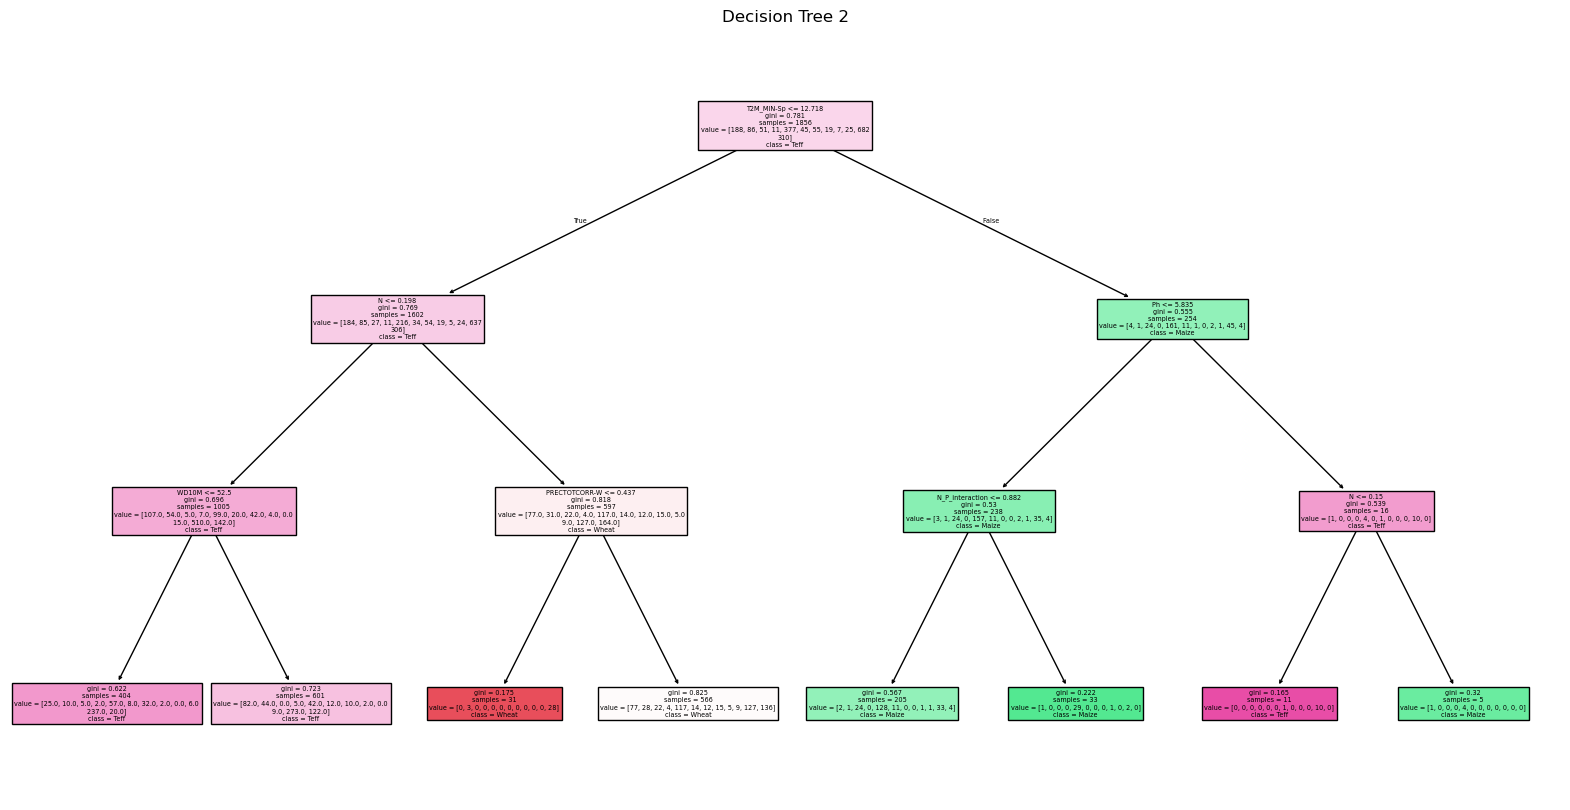

In [120]:
# Decision tree 2
dt2 = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42)

# Train the model
dt2.fit(X_train, y_train)

# Predict on the test set
y_pred_dt2 = dt2.predict(X_test)

# --- Evaluate the Model ---
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_dt2)
print(f"Accuracy: {accuracy:.2f}")

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_dt2))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_dt2)
print("Confusion Matrix:")
print(conf_matrix)

# --- Visualize the Decision Tree ---
plt.figure(figsize=(20, 10))
plot_tree(dt2, feature_names=X.columns, class_names=pdf['label'].unique(), filled=True)
plt.title("Decision Tree 2")
plt.show()

Accuracy: 0.45
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.00      0.00      0.00        23
           2       0.00      0.00      0.00        12
           3       0.00      0.00      0.00         7
           4       0.48      0.45      0.46        92
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         9
          10       0.47      0.72      0.57       170
          11       0.37      0.56      0.45        78

    accuracy                           0.45       465
   macro avg       0.11      0.14      0.12       465
weighted avg       0.33      0.45      0.38       465

Confusion Matrix:
[[  0   0   0   0   0   0   0   0   0   0  31  18]
 [  0   0   0   0   1   0 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


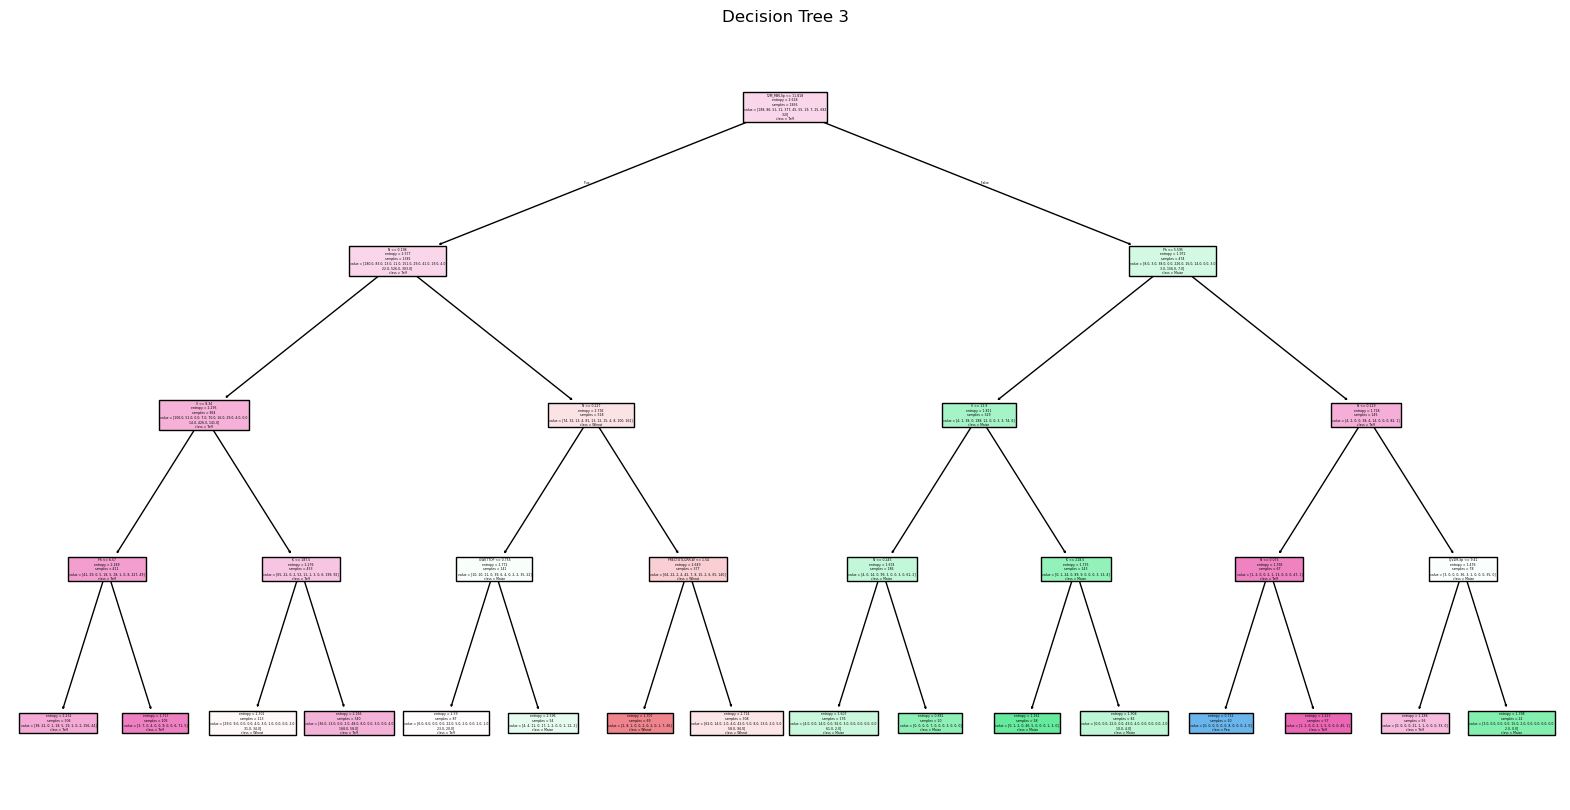

In [125]:
# Decision tree 3
dt3 = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)

# Train the model
dt3.fit(X_train, y_train)

# Predict on the test set
y_pred_dt3 = dt3.predict(X_test)

# --- Evaluate the Model ---
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_dt3)
print(f"Accuracy: {accuracy:.2f}")

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_dt3))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_dt3)
print("Confusion Matrix:")
print(conf_matrix)

# --- Visualize the Decision Tree ---
plt.figure(figsize=(20, 10))
plot_tree(dt3, feature_names=X.columns, class_names=pdf['label'].unique(), filled=True)
plt.title("Decision Tree 3")
plt.show()

#### Regression

In [140]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [141]:
X_train

,Soilcolor,Ph,K,P,N,Zn,S,QV2M-W,QV2M-Sp,QV2M-Su,...,PRECTOTCORR-Sp,PRECTOTCORR-Su,PRECTOTCORR-Au,WD10M,GWETTOP,CLOUD_AMT,WS2M_RANGE,PS,Ph_binned,N_P_interaction
116,6,5.60,215.0,2.00,0.215300,0.60,9.00,7.933333,8.403333,11.413333,...,3.246667,13.013333,3.463333,88.38,0.74,59.11,6.26,76.54,2,0.430600
7,6,5.30,125.0,8.00,0.227900,0.90,23.00,8.506667,9.340000,12.166667,...,5.203333,17.816667,5.823333,36.06,0.77,59.11,5.41,77.29,1,1.823200
153,11,5.30,208.0,3.40,0.209643,0.90,17.50,8.566667,9.663333,12.736667,...,5.660000,19.920000,7.420000,14.25,0.80,59.11,6.06,78.58,1,0.712786
101,6,6.47,286.0,5.04,0.120000,2.04,14.80,7.933333,8.403333,11.413333,...,3.246667,13.013333,3.463333,88.38,0.74,59.11,6.26,76.54,0,0.604800
307,11,5.30,217.0,1.00,0.246300,1.10,13.00,8.910000,9.480000,12.246667,...,4.610000,17.446667,5.803333,68.94,0.73,59.11,5.44,78.25,1,0.246300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,11,6.40,429.0,7.00,0.120900,1.20,14.00,8.506667,9.340000,12.166667,...,5.203333,17.816667,5.823333,36.06,0.77,59.11,5.41,77.29,0,0.846300
71,6,5.70,391.0,3.00,0.119800,1.40,6.00,8.910000,9.480000,12.246667,...,4.610000,17.446667,5.803333,68.94,0.73,59.11,5.44,78.25,2,0.359400
106,6,5.20,429.0,4.00,0.000262,1.90,18.00,8.910000,9.480000,12.246667,...,4.610000,17.446667,5.803333,68.94,0.73,59.11,5.44,78.25,1,0.001047
270,11,6.48,163.0,3.00,0.160000,1.50,6.00,7.586667,8.136667,11.430000,...,2.266667,11.766667,2.960000,88.31,0.63,59.11,6.01,77.15,0,0.480000


Logistic Regression - Accuracy: 0.79
Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        54
           1       0.57      0.25      0.35        16

    accuracy                           0.79        70
   macro avg       0.69      0.60      0.61        70
weighted avg       0.76      0.79      0.75        70



/tmp/ipykernel_486/258476909.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reg['label_encoded'] = label_encoder.fit_transform(data_reg['label'])  # Barley = 0, Bean = 1
/tmp/ipykernel_486/258476909.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reg['Soilcolor'] = label_encoder.fit_transform(data_reg['Soilcolor'])
/tmp/ipykernel_486/258476909.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

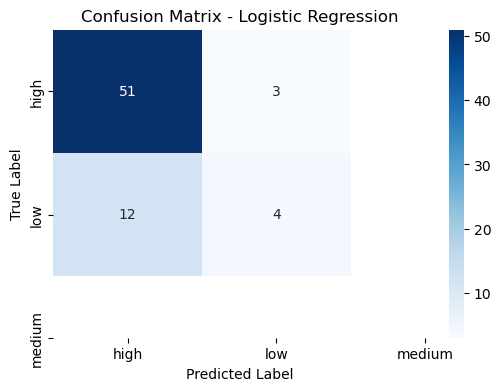

In [142]:
data_reg= pdf[pdf['label'].isin(['Barley', 'Bean'])]

# Encode the labels into binary values
label_encoder = LabelEncoder()
data_reg['label_encoded'] = label_encoder.fit_transform(data_reg['label'])  # Barley = 0, Bean = 1

data_reg['Soilcolor'] = label_encoder.fit_transform(data_reg['Soilcolor'])
data_reg['Ph_binned'] = label_encoder.fit_transform(data_reg['Ph_binned'])
# Define features (X) and target (y)
X = data_reg.drop(columns=['label', 'label_encoded'])  # Drop the original and encoded labels
y = data_reg['label_encoded']  # Target column
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (optional for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Logistic Regression ---
# Initialize and train the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_logistic = log_reg.predict(X_test_scaled)

# Evaluate the Logistic Regression model
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print(f"Logistic Regression - Accuracy: {accuracy_logistic:.2f}")
print("Logistic Regression - Classification Report:")
print(classification_report(y_test, y_pred_logistic))

# Confusion Matrix for Logistic Regression
conf_matrix_logistic = confusion_matrix(y_test, y_pred_logistic)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_logistic, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### MNB for new double class data_reg

Multinomial Naive Bayes - Accuracy: 0.63
Multinomial Naive Bayes - Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.70      0.75        54
           1       0.27      0.38      0.32        16

    accuracy                           0.63        70
   macro avg       0.53      0.54      0.53        70
weighted avg       0.67      0.63      0.65        70



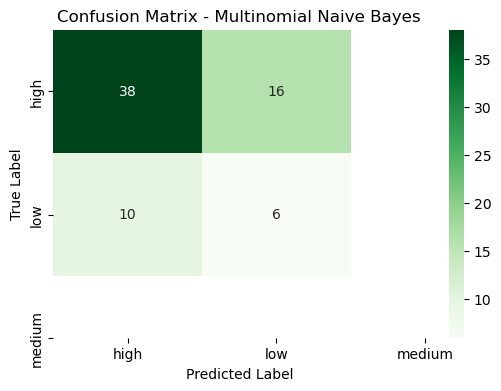

Logistic Regression Accuracy: 0.79
Multinomial Naive Bayes Accuracy: 0.63


In [143]:
# --- Multinomial Naive Bayes ---
# Initialize and train the Multinomial Naive Bayes model
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

# Predict on the test set
y_pred_mnb = mnb.predict(X_test)

# Evaluate the Multinomial Naive Bayes model
accuracy_mnb = accuracy_score(y_test, y_pred_mnb)
print(f"Multinomial Naive Bayes - Accuracy: {accuracy_mnb:.2f}")
print("Multinomial Naive Bayes - Classification Report:")
print(classification_report(y_test, y_pred_mnb))

# Confusion Matrix for Multinomial Naive Bayes
conf_matrix_mnb = confusion_matrix(y_test, y_pred_mnb)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_mnb, annot=True, fmt='d', cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - Multinomial Naive Bayes")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# --- Comparison ---
# Print accuracy comparison
print(f"Logistic Regression Accuracy: {accuracy_logistic:.2f}")
print(f"Multinomial Naive Bayes Accuracy: {accuracy_mnb:.2f}")